In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler, OneHotEncoder, FunctionTransformer
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
#import data
df = pd.read_csv("train.csv")
#exploring data
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [3]:
# separate target from predictors
df.dropna(axis=0, subset=['Response'], inplace=True)
y =df[['Response']]
df=df.set_index("id")


In [4]:
Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

The number of missing entries before cleaning: 0.0 %


In [5]:
#split data to numeric and categorical
numerical_columns=['Age', 'Region_Code','Annual_Premium','Vintage']
categorical_columns=['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']

#checking the numerical columns
df.describe()


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


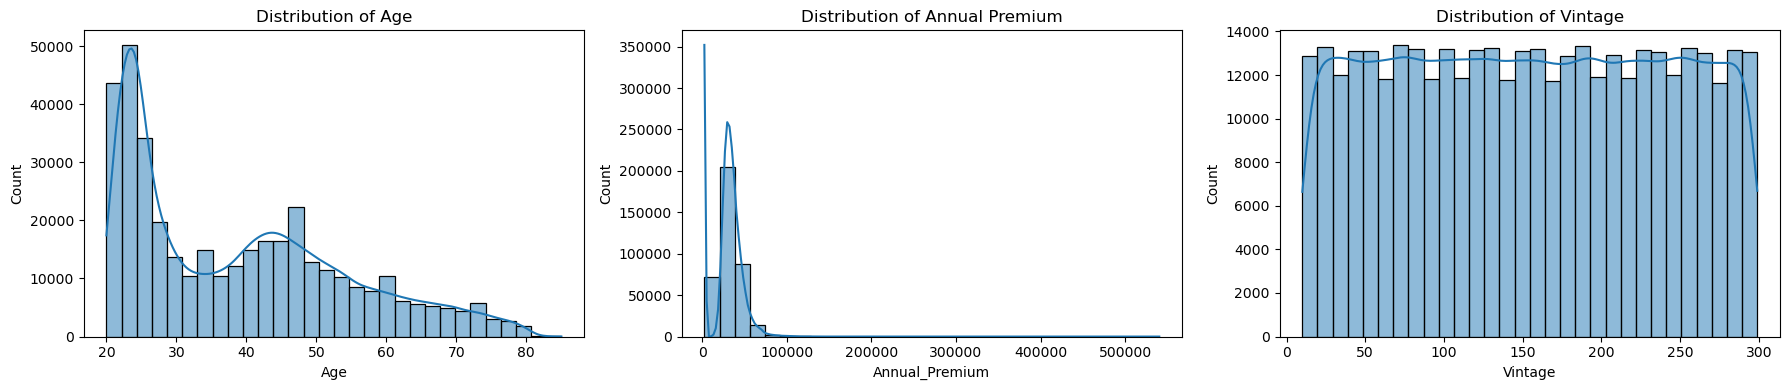

In [6]:
# Distribution of Numerical Features
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['Age'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribution of Age')
sns.histplot(df['Annual_Premium'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribution of Annual Premium')
sns.histplot(df['Vintage'], kde=True, bins=30, ax=axes[2])
axes[2].set_title('Distribution of Vintage')
plt.tight_layout()
plt.show()

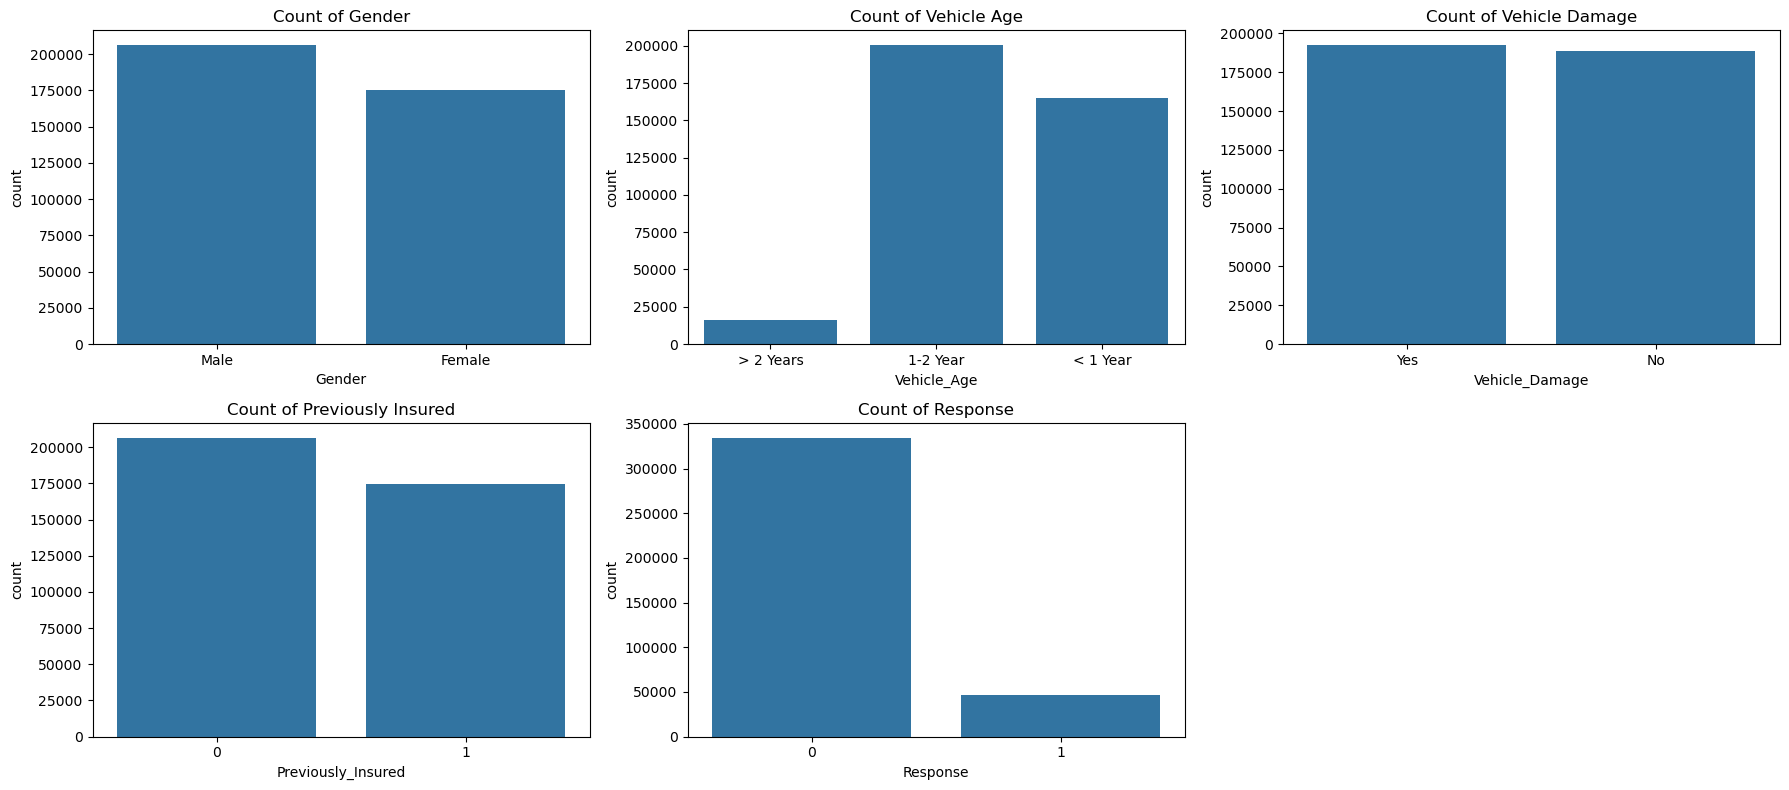

In [7]:
# Count Plots of Categorical Features
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
sns.countplot(x='Gender', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Count of Gender')
sns.countplot(x='Vehicle_Age', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Count of Vehicle Age')
sns.countplot(x='Vehicle_Damage', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Count of Vehicle Damage')
sns.countplot(x='Previously_Insured', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Count of Previously Insured')
sns.countplot(x='Response', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Count of Response')
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


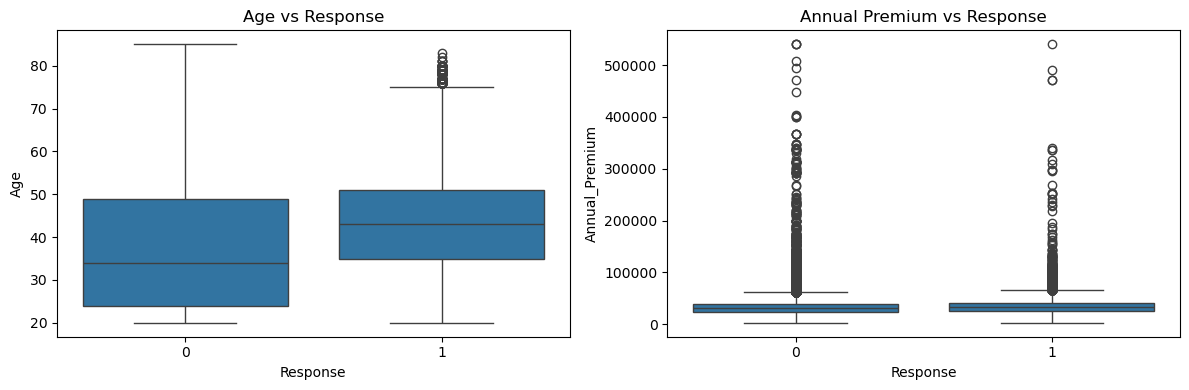

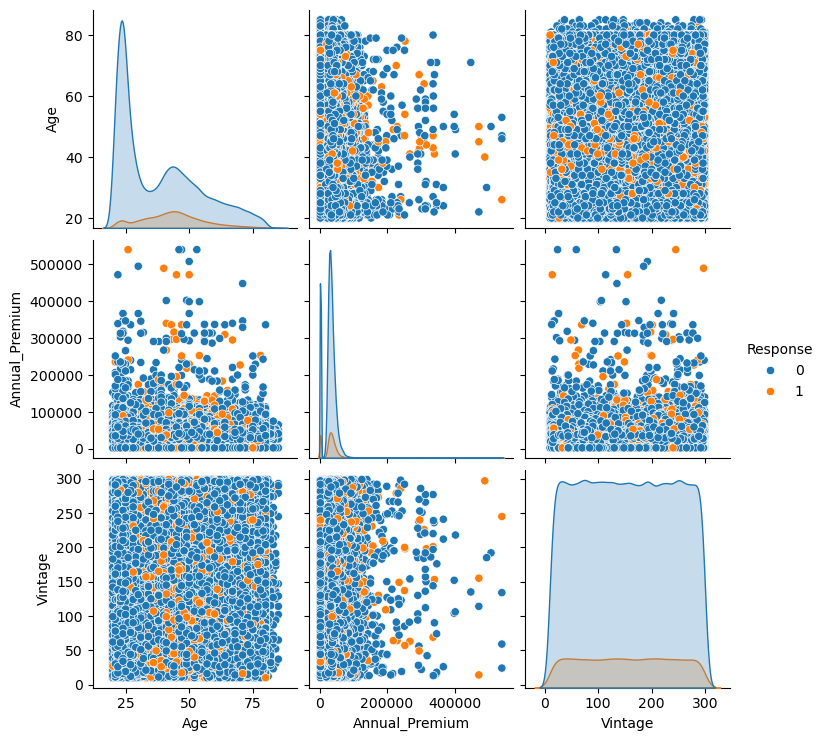

In [8]:
# Box Plots to Compare Categories
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='Response', y='Age', data=df, ax=axes[0])
axes[0].set_title('Age vs Response')
sns.boxplot(x='Response', y='Annual_Premium', data=df, ax=axes[1])
axes[1].set_title('Annual Premium vs Response')
plt.tight_layout()
plt.show()

# Pairplot for Multivariate Analysis
sns.pairplot(df[['Age', 'Annual_Premium', 'Vintage', 'Response']], hue='Response', height=2.5)
plt.show()

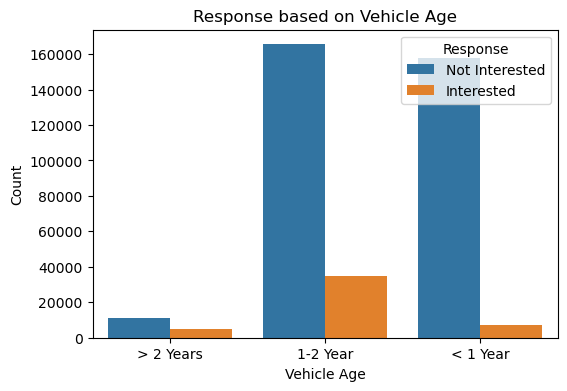

In [9]:
# Example: Count plot of Response based on Vehicle Age
plt.figure(figsize=(6, 4))
sns.countplot(x='Vehicle_Age', hue='Response', data=df)
plt.title('Response based on Vehicle Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.legend(title='Response', loc='upper right', labels=['Not Interested', 'Interested'])
plt.show()


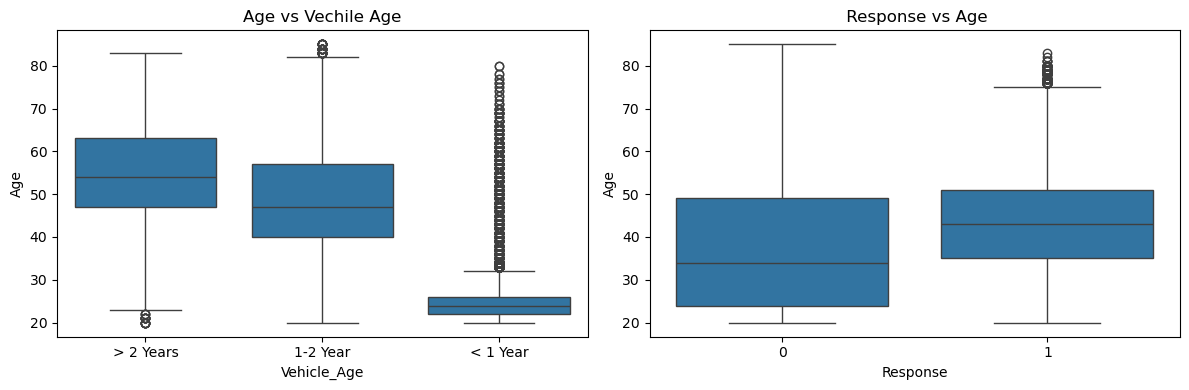

In [12]:
# Box Plots to Compare Categories betweeen the age of vechile and age of driver
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='Vehicle_Age', y='Age', data=df, ax=axes[0])
axes[0].set_title('Age vs Vechile Age')
sns.boxplot( x='Response',y='Age', data=df, ax=axes[1])
axes[1].set_title(' Response vs Age')
plt.tight_layout()
plt.show()


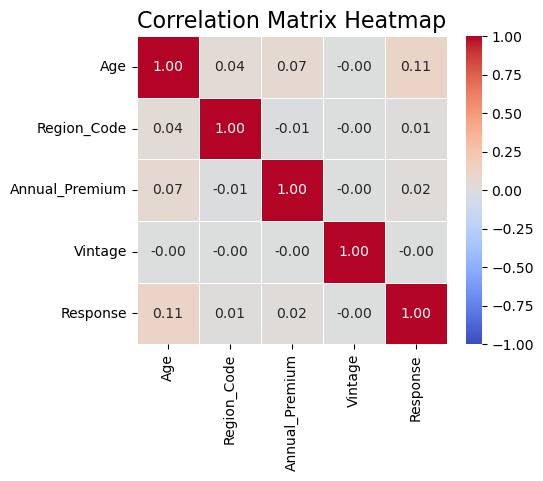

In [99]:
#to identify correlated variables we do correaltion matrix,
# Correlation is as a mean to see which variables are important as well as to investigate any multicollinearity between our independent predictors.
correlation = df[numerical_columns + ['Response']].corr()
correlation

# Set up the matplotlib figure
plt.figure(figsize=(5, 4))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Set plot title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

In [107]:
# Detect outliers using IQR method
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers in 'Annual_Premium': {num_outliers}")
    print(f'Outliers in {col}:\n{outliers}\n')

Number of outliers in 'Annual_Premium': 0
Outliers in Age:
Empty DataFrame
Columns: [Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []

Number of outliers in 'Annual_Premium': 0
Outliers in Region_Code:
Empty DataFrame
Columns: [Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []

Number of outliers in 'Annual_Premium': 10320
Outliers in Annual_Premium:
        Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                      
26      Female   21                1         28.0                   1   
38      Female   25                1         28.0                   1   
68        Male   60                1         28.0                   0   
140       Male   21                1         29.0              

Outliers are only detected in annual premium. Since the reason for the amount of premiums maybe in unobserved variables, I decided to not remove the outliers.

In [18]:
# Splitting data
X = df.drop(columns=['Response'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
# Define the transformers for numeric and categorical data
numerical_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='mean')), #in case we get new data with missing values
    ('scaler', RobustScaler()) #tried using others too
])
#The Pipeline function in scikit-learn is used to streamline a sequence of data processing steps.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #in case we would have missing values in the test data ( we get later on)
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False))
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)



In [24]:
#definig a functin to evalute models
def evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'LGBMClassifier': LGBMClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0)
    }

    results = {}

    for model_name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=4)),  # Adjust n_components as needed
            ('classifier', model)
        ])

        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test)

        # Evaluate the model
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            'classification_report': report,
            'confusion_matrix': cm
        }

    return results


In [25]:
# Evaluate models
results = evaluate_models(X_train, y_train, X_test, y_test)

# Display results
for model_name, result in results.items():
    print(f"Results for {model_name}:\n")
    print("Classification Report:")
    print(pd.DataFrame(result['classification_report']).transpose())
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])
    print("\n" + "-"*80 + "\n")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[LightGBM] [Info] Number of positive: 37368, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968376
[LightGBM] [Info] Start training from score -1.968376
Results for Logistic Regression:

Classification Report:
              precision    recall  f1-score       support
0              0.877447  0.999985  0.934717  66880.000000
1              0.500000  0.000107  0.000214   9342.000000
accuracy       0.877437  0.877437  0.877437      0.877437
macro avg      0.688723  0.500046  0.467466  76222.000000
weighted avg   0.831186  0.877437  0.820181  76222.000000

Confusion Matrix:
[[66879     1]
 [

In [36]:
#the results show imbalanced data, therefore we have to adress it.
# Define different resampling strategies
resampling_strategies = {
    'RandomUnderSampler_0.5': RandomUnderSampler(sampling_strategy=0.5, random_state=42),
    'RandomUnderSampler_0.3': RandomUnderSampler(sampling_strategy=0.3, random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'ClusterCentroids': ClusterCentroids(random_state=42),
    'TomekLinks': TomekLinks(),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

# Define the models to be evaluated
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LGBMClassifier': LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, silent=True)
}

# Function to evaluate a pipeline with different models and resampling strategies
def evaluate_pipeline(X_train, y_train, X_test, y_test, model, resampling_strategy):
    # Apply resampling
    X_res, y_res = resampling_strategy.fit_resample(X_train, y_train)
    
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_res, y_res)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Print the classification report
    print(f'Classification Report ({type(model).__name__} with {type(resampling_strategy).__name__}):')
    print(classification_report(y_test, y_pred))
    print('-'*80)

# Evaluate each model with each resampling strategy
for model_name, model in models.items():
    for strategy_name, strategy in resampling_strategies.items():
        print(f'Evaluating {model_name} with {strategy_name}...')
        evaluate_pipeline(X_train, y_train, X_test, y_test, model, strategy)


Evaluating RandomForest with RandomUnderSampler_0.5...
Classification Report (RandomForestClassifier with RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     66880
           1       0.30      0.65      0.41      9342

    accuracy                           0.77     76222
   macro avg       0.62      0.72      0.63     76222
weighted avg       0.86      0.77      0.80     76222

--------------------------------------------------------------------------------
Evaluating RandomForest with RandomUnderSampler_0.3...
Classification Report (RandomForestClassifier with RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     66880
           1       0.32      0.42      0.36      9342

    accuracy                           0.82     76222
   macro avg       0.62      0.65      0.63     76222
weighted avg       0.84      0.82      0.83     76222

-----------

ValueError: could not convert string to float: 'Male'

In [37]:

# # Preprocess the training data

# X_train_preprocessed = preprocessor.fit_transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

# # Define different resampling strategies
# resampling_strategies = {
#     'RandomUnderSampler_0.5': RandomUnderSampler(sampling_strategy=0.5, random_state=42),
#     'RandomUnderSampler_0.3': RandomUnderSampler(sampling_strategy=0.3, random_state=42),
#     'RandomOverSampler': RandomOverSampler(random_state=42),
#     'ClusterCentroids': ClusterCentroids(random_state=42),
#     'TomekLinks': TomekLinks(),
#     'SMOTE': SMOTE(random_state=42),
#     'ADASYN': ADASYN(random_state=42)
# }

# # Function to evaluate a pipeline with different models and resampling strategies
# def evaluate_pipeline(X_train, y_train, X_test, y_test, model, resampling_strategy):
#     # Apply resampling
#     X_res, y_res = resampling_strategy.fit_resample(X_train, y_train)
    
#     # Create the pipeline
#     pipeline = Pipeline(steps=[
#         ('classifier', model)
#     ])
    
#     # Fit the model
#     pipeline.fit(X_res, y_res)
    
#     # Predict on the test set
#     y_pred = pipeline.predict(X_test)
    
#     # Print the classification report
#     print(f'Classification Report ({type(model).__name__} with {type(resampling_strategy).__name__}):')
#     print(classification_report(y_test, y_pred))
#     print('-'*80)

# # Evaluate each model with each resampling strategy
# for model_name, model in models.items():
#     for strategy_name, strategy in resampling_strategies.items():
#         print(f'Evaluating {model_name} with {strategy_name}...')
#         evaluate_pipeline(X_train_preprocessed, y_train, X_test_preprocessed, y_test, model, strategy)


Evaluating RandomForest with RandomUnderSampler_0.5...
Classification Report (RandomForestClassifier with RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     66880
           1       0.30      0.65      0.41      9342

    accuracy                           0.77     76222
   macro avg       0.62      0.72      0.63     76222
weighted avg       0.86      0.77      0.80     76222

--------------------------------------------------------------------------------
Evaluating RandomForest with RandomUnderSampler_0.3...
Classification Report (RandomForestClassifier with RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     66880
           1       0.32      0.42      0.36      9342

    accuracy                           0.82     76222
   macro avg       0.62      0.65      0.63     76222
weighted avg       0.84      0.82      0.83     76222

-----------

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     66880
           1       0.31      0.77      0.45      9342

    accuracy                           0.76     76222
   macro avg       0.64      0.77      0.65     76222
weighted avg       0.88      0.76      0.80     76222

--------------------------------------------------------------------------------
Evaluating XGBClassifier with RandomUnderSampler_0.3...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     66880
           1       0.35      0.42      0.38      9342

    accuracy                           0.83     76222
   macro avg       0.63      0.66      0.64     76222
weighted avg       0.85      0.83      0.84     76222

--------------------------------------------------------------------------------
Evaluating XGBClassifier with RandomOverSampler...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with RandomOverSampler):
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     66880
           1       0.28      0.90      0.43      9342

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.62     76222
weighted avg       0.90      0.71      0.76     76222

--------------------------------------------------------------------------------
Evaluating XGBClassifier with ClusterCentroids...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with ClusterCentroids):
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     66880
           1       0.24      0.96      0.39      9342

    accuracy                           0.62     76222
   macro avg       0.62      0.77      0.56     76222
weighted avg       0.90      0.62      0.69     76222

--------------------------------------------------------------------------------
Evaluating XGBClassifier with TomekLinks...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with TomekLinks):
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     66880
           1       0.42      0.05      0.09      9342

    accuracy                           0.88     76222
   macro avg       0.65      0.52      0.51     76222
weighted avg       0.83      0.88      0.83     76222

--------------------------------------------------------------------------------
Evaluating XGBClassifier with SMOTE...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     66880
           1       0.31      0.71      0.43      9342

    accuracy                           0.77     76222
   macro avg       0.63      0.74      0.64     76222
weighted avg       0.87      0.77      0.80     76222

--------------------------------------------------------------------------------
Evaluating XGBClassifier with ADASYN...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBClassifier with ADASYN):
              precision    recall  f1-score   support

           0       0.95      0.76      0.85     66880
           1       0.30      0.73      0.43      9342

    accuracy                           0.76     76222
   macro avg       0.63      0.75      0.64     76222
weighted avg       0.87      0.76      0.80     76222

--------------------------------------------------------------------------------
Evaluating LGBMClassifier with RandomUnderSampler_0.5...
[LightGBM] [Info] Number of positive: 37368, number of negative: 74736
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 112104, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> 

Based on the results the best method to handle the unbalanced data is RandomUnderSampler 0.5.
Therefore further one I will use this method to evalute models.